# STGNN WAVE
Bunu implement ettim
https://github.com/dmlc/dgl/tree/master/examples/pytorch/stgcn_wave

Buna da bakmalıyım bi ara
https://github.com/chnsh/DCRNN_PyTorch

In [3]:
import dgl
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing import StandardScaler

In [4]:
def data_transform(data, n_window, n_ahead, device=torch.device("cpu")):
    """
    :param data: rows for time indices, columns for locations
        currently does not support features
    :param n_window: history length
    :param n_ahead: next time index to predict
    """
    # produce data slices for training and testing
    n_obs, n_loc = data.shape
    
    num = n_obs - n_window - n_ahead
    x = np.zeros([num, 1, n_window, n_loc]) # features might end up being in second dimension
    y = np.zeros([num, n_loc])
    
    count = 0
    for start in range(num):
        x[count, :, :, :] = data[start: start + n_window].reshape(1, n_window, n_loc)
        y[count] = data[start + n_window + n_ahead - 1]
        count += 1
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [5]:
data = pd.read_parquet("data/wind/2019-01-24_outlier_removed.parquet")    
data = data[~data["rt_plant_id"].isin([2397, 2420, 2538])]
assert data.rt_plant_id.nunique() == 98
plant_mapping = {k:v for k,v in zip(np.sort(data.rt_plant_id.astype(int).unique()), range(98))}
data.rt_plant_id = data.rt_plant_id.map(plant_mapping) # zaten sort ettiği için gerek yok aslında


In [8]:
data = data[(data["forecast_dt"] > "2020-08-31") & (data["forecast_dt"] < "2021-01-01")]
data.head()

,epoch,production,rt_plant_id,forecast_dt,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,VGRD_80.m.above.ground.NE,VGRD_80.m.above.ground.SE,production_lower,production_upper,is_outlier,production_cleaned
14035,1598824800,2.0,24,2020-08-31 01:00:00+03:00,-2.86062,-5.80062,-4.99062,-4.66062,-0.528602,-2.11860,-0.298602,-0.448602,0.0,10.0,False,2.0
14036,1598828400,2.0,24,2020-08-31 02:00:00+03:00,-2.53005,-4.94005,-4.51005,-4.28005,-0.820090,-3.17009,-0.420090,-0.640090,0.0,10.0,False,2.0
14037,1598832000,2.8,24,2020-08-31 03:00:00+03:00,-1.97141,-6.19141,-4.20141,-4.75141,-1.644470,-5.45447,-0.614468,-2.484470,0.0,10.0,False,2.8
14038,1598835600,2.8,24,2020-08-31 04:00:00+03:00,-3.13687,-7.24687,-3.45687,-5.32687,-2.518730,-5.09873,-1.218730,-2.638730,0.0,10.0,False,2.8
14039,1598839200,2.8,24,2020-08-31 05:00:00+03:00,-3.46972,-7.32972,-3.95972,-5.45972,-3.046720,-4.81672,-1.276720,-2.396720,0.0,10.0,False,2.8


In [9]:
print(data.forecast_dt.nunique())

2951


In [10]:
def generate_adjacency_matrix(df, threshold=0.5):    
    data = df[["forecast_dt", "rt_plant_id", "production"]]
    data = pd.pivot_table(data, index="forecast_dt", columns="rt_plant_id", values="production")

    A = abs(data.corr())
    A = A[A > threshold].fillna(0)
    return A

In [23]:
adj = generate_adjacency_matrix(data)
sp_mx = sp.coo_matrix(adj)
G = dgl.from_scipy(sp_mx, eweight_name="weight")

print(len(G.all_edges()[0]))
print(len(G.edata["weight"]))

G = dgl.remove_self_loop(G)
print(len(G.all_edges()[0]))
print(len(G.edata["weight"]))

G = dgl.add_self_loop(G)
print(len(G.all_edges()[0]))
print(len(G.edata["weight"]))

6788
6788
6690
6690
6788
6788


In [30]:
df_ = pd.pivot_table(
    data[["production", "rt_plant_id", "forecast_dt"]], 
    index="forecast_dt", 
    columns="rt_plant_id", 
    values="production")
df_.head()

rt_plant_id,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
forecast_dt,,,,,,,,,,,,,,,,,,,,,
2020-08-31 01:00:00+03:00,11.2,0.0,3.0,88.0,135.0,4.42,4.74,27.0,0.0,0.0,...,25.0,17.32,11.20,0.03,5.46,11.92,2.52,24.06,21.0,0.1
2020-08-31 02:00:00+03:00,14.0,0.0,2.5,106.0,163.0,4.68,4.84,16.0,0.0,0.0,...,26.0,15.20,12.20,0.00,5.49,12.05,3.81,23.72,20.0,0.1
2020-08-31 03:00:00+03:00,20.8,0.0,1.3,94.0,159.0,4.56,7.72,24.0,0.0,10.0,...,30.0,12.05,11.13,0.00,6.54,12.50,4.61,23.50,20.0,1.1
2020-08-31 04:00:00+03:00,21.5,0.0,1.9,89.0,172.0,4.47,8.39,30.0,1.0,12.0,...,30.0,14.36,12.18,0.03,7.77,12.50,1.67,23.76,21.0,4.2
2020-08-31 05:00:00+03:00,20.2,0.0,2.8,118.0,149.0,5.14,11.89,30.0,0.0,11.0,...,27.0,19.58,13.50,0.49,2.55,12.44,0.95,24.01,20.0,10.4


In [31]:
df = df_.to_numpy()
if True:
    df = df[round(0.5*len(df)):round(0.7*len(df))]
num_samples, num_nodes = df.shape
print(num_samples, num_nodes)

590 98


In [32]:
len_val = round(num_samples * 0.099)
len_train = round(num_samples * 0.9)
train = df[: len_train]
val = df[len_train: len_train + len_val]
test = df[len_train + len_val:]
print(len(train), len(val), len(test))

scaler = StandardScaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

531 58 1


In [ ]:
pd.DataFrame(scaler.inverse_transform(train))

In [34]:
n_window, n_ahead = 2 * 24, 1
x_train, y_train = data_transform(train, n_window, n_ahead)
x_val, y_val = data_transform(val, n_window, n_ahead)
# x_test, y_test = data_transform(test, n_window, n_ahead)

In [35]:
batch_size = 50
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
# test_data = torch.utils.data.TensorDataset(x_test, y_test)
# test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [36]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

class TemporalConvLayer(nn.Module):
    ''' Temporal convolution layer.
    
    arguments
    ---------
    c_in : int
        The number of input channels (features)
    c_out : int
        The number of output channels (features)
    dia : int
        The dilation size
    '''
    def __init__(self, c_in, c_out, dia = 1):
        super(TemporalConvLayer, self).__init__()
        self.c_out = c_out
        self.c_in = c_in
        self.conv = nn.Conv2d(c_in, c_out, (2, 1), 1, dilation = dia, padding = (0,0))


    def forward(self, x):
        return torch.relu(self.conv(x))


class SpatioConvLayer(nn.Module):
    def __init__(self, c, Lk): # c : hidden dimension Lk: graph matrix
        super(SpatioConvLayer, self).__init__()
        self.g = Lk
        self.gc = GraphConv(c, c, activation=F.relu)

    def init(self):
        stdv = 1. / math.sqrt(self.W.weight.size(1))
        self.W.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = x.transpose(0, 3)
        x = x.transpose(1, 3)
        output = self.gc(self.g, x)
        output = output.transpose(1, 3)
        output = output.transpose(0, 3)
        return torch.relu(output)

class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConvLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class STGCN_WAVE(nn.Module):
    def __init__(self, c, T, n, Lk, device=torch.device("cpu"), control_str='TNTSTNTST'):
        super(STGCN_WAVE, self).__init__()
        self.control_str = control_str
        self.num_layers = len(control_str)
        self.layers = nn.ModuleList([])
        cnt = 0
        diapower = 0
        for i in range(self.num_layers):
            i_layer = control_str[i]
            if i_layer == 'T': # Temporal Layer
                self.layers.append(TemporalConvLayer(c[cnt], c[cnt + 1], dia = 2**diapower))
                diapower += 1
                cnt += 1
            if i_layer == 'S': # Spatio Layer
                self.layers.append(SpatioConvLayer(c[cnt], Lk))
            if i_layer == 'N': # Norm Layer
                self.layers.append(nn.LayerNorm([n,c[cnt]]))
        self.output = OutputLayer(c[cnt], T + 1 - 2**(diapower), n)
        for layer in self.layers:
            layer = layer.to(device)
    
    def forward(self, x):
        for i in range(self.num_layers):
            i_layer = self.control_str[i]
            if i_layer == 'N':
                x = self.layers[i](x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  
            else:
                x = self.layers[i](x)
        return self.output(x)

In [37]:
blocks = [1, 16, 32, 64, 32, 128]
lr = 0.001

In [38]:
loss = nn.MSELoss()
device=torch.device("cpu")
G = G.to(device)
model = STGCN_WAVE(blocks, n_window, num_nodes, G).to(device)

In [39]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

In [40]:
save_path = "stgcnwavemodel.pt"
epochs = 10

def evaluate_model(model, loss, data_iter):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            l = loss(y_pred, y)
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n


def evaluate_metric(model, data_iter, scaler):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE

In [41]:
min_val_loss = np.inf
for epoch in range(1, epochs + 1):
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

    

/home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch 1 , train loss: 8.999580574480824 , validation loss: 3.215144634246826
epoch 2 , train loss: 0.7609817369597581 , validation loss: 1.1514554023742676
epoch 3 , train loss: 0.5548242067153029 , validation loss: 0.8691270351409912
epoch 4 , train loss: 0.46555631635594663 , validation loss: 0.6670680046081543
epoch 5 , train loss: 0.5019499325653329 , validation loss: 0.7049445509910583
epoch 6 , train loss: 0.36656127913364234 , validation loss: 0.8759174942970276
epoch 7 , train loss: 0.3111508943727897 , validation loss: 0.3571151793003082
epoch 8 , train loss: 0.31470688262421065 , validation loss: 0.39937448501586914
epoch 9 , train loss: 0.3474070293774743 , validation loss: 0.4240894615650177
epoch 10 , train loss: 0.287597596274372 , validation loss: 0.5419701933860779


In [ ]:
# adj matrixi train datadan oluştur

In [42]:
best_model = STGCN_WAVE(blocks, n_window, num_nodes, G).to(device)
best_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [43]:
l = evaluate_model(best_model, loss, val_iter)
MAE, MAPE, RMSE = evaluate_metric(best_model, val_iter, scaler)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

test loss: 0.3571151793003082 
MAE: 6.876022599384087 , MAPE: 1149652.608428692 , RMSE: 12.752290990834698


In [46]:
import matplotlib.pyplot as plt

In [47]:
def plot(y, y_pred, i=0):
    y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
    y = scaler.inverse_transform(y.cpu().numpy())
    plt.plot(y[:, i], label="y")
    plt.plot(y_pred[:, i], label="y_pred")
    plt.legend()
    plt.show()

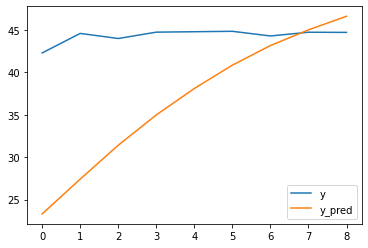

In [61]:
best_model.eval()
with torch.no_grad():
    x, y = list(val_iter)[0]
    y_pred = best_model(x).view(len(x), -1)
    plot(y, y_pred, 84)
        

In [97]:
print(x_val.shape, y_val.shape)

torch.Size([9, 1, 48, 98]) torch.Size([9, 98])


In [140]:
pd.options.display.float_format = "{:,.2f}".format

In [141]:
def to_df(x, transform=True):
    x = x.reshape(-1, 98).cpu().numpy()
    if transform:
        x = scaler.inverse_transform(x)
    return pd.DataFrame(x)

In [154]:
df_[round(0.5*len(df_)) + len_train: round(0.5*len(df_)) + len_train + len_val]


rt_plant_id,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
forecast_dt,,,,,,,,,,,,,,,,,,,,,
2020-11-22 16:00:00+03:00,66.20,0.00,18.20,174.00,227.00,12.35,1.84,5.00,22.00,12.00,...,60.00,9.94,0.32,15.56,1.86,1.95,9.90,19.99,26.00,9.50
2020-11-22 17:00:00+03:00,75.00,1.00,15.90,197.00,219.00,10.43,4.61,5.70,23.00,19.00,...,58.00,10.88,4.90,14.20,3.77,5.19,10.00,22.85,27.00,9.30
2020-11-22 18:00:00+03:00,78.30,0.00,16.60,196.00,223.00,9.68,8.47,12.00,24.00,23.00,...,55.00,8.94,7.45,10.88,4.47,7.60,9.90,24.14,28.00,10.00
2020-11-22 19:00:00+03:00,77.10,1.00,18.00,207.00,194.00,9.57,9.60,11.80,26.00,27.00,...,44.00,12.23,4.30,15.58,7.99,8.11,9.95,24.31,26.00,10.40
2020-11-22 20:00:00+03:00,76.80,1.00,19.00,198.00,164.00,10.01,9.79,14.50,18.00,27.00,...,41.00,17.59,10.07,22.36,8.46,8.65,9.60,23.85,27.00,12.60
2020-11-22 21:00:00+03:00,69.70,0.00,18.70,165.00,146.00,8.04,10.18,13.70,4.00,24.00,...,39.00,14.18,16.60,27.64,5.51,7.88,9.80,23.99,27.00,16.30
2020-11-22 22:00:00+03:00,51.10,1.00,18.70,186.00,130.00,4.54,8.77,14.50,1.00,20.00,...,40.00,9.95,17.20,28.17,5.77,8.27,8.00,24.72,28.00,15.40
2020-11-22 23:00:00+03:00,32.80,1.00,18.30,187.00,125.00,3.21,7.83,14.41,2.00,18.00,...,34.00,3.32,16.38,24.50,7.92,6.27,3.64,25.06,27.00,14.00
2020-11-23 00:00:00+03:00,12.00,0.00,12.60,199.00,130.00,3.48,5.94,16.59,5.00,19.00,...,33.00,0.00,12.79,17.47,7.62,6.27,2.56,25.15,22.00,20.00


In [152]:
df[len_train: len_train + len_val]

array([[66.2 ,  0.  , 18.2 , ..., 19.99, 26.  ,  9.5 ],
       [75.  ,  1.  , 15.9 , ..., 22.85, 27.  ,  9.3 ],
       [78.3 ,  0.  , 16.6 , ..., 24.14, 28.  , 10.  ],
       ...,
       [75.6 ,  1.  , 19.1 , ..., 24.45, 27.  , 13.5 ],
       [64.9 ,  1.  , 19.2 , ..., 24.49, 27.  , 20.  ],
       [82.2 ,  1.  , 20.  , ..., 23.83, 30.  , 20.  ]])

In [147]:
to_df(x_val[0, 0]).head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,66.20,0.00,18.20,174.00,227.00,12.35,1.84,5.00,22.00,12.00,...,60.00,9.94,0.32,15.56,1.86,1.95,9.90,19.99,26.00,9.50
1,75.00,1.00,15.90,197.00,219.00,10.43,4.61,5.70,23.00,19.00,...,58.00,10.88,4.90,14.20,3.77,5.19,10.00,22.85,27.00,9.30
2,78.30,0.00,16.60,196.00,223.00,9.68,8.47,12.00,24.00,23.00,...,55.00,8.94,7.45,10.88,4.47,7.60,9.90,24.14,28.00,10.00
3,77.10,1.00,18.00,207.00,194.00,9.57,9.60,11.80,26.00,27.00,...,44.00,12.23,4.30,15.58,7.99,8.11,9.95,24.31,26.00,10.40
4,76.80,1.00,19.00,198.00,164.00,10.01,9.79,14.50,18.00,27.00,...,41.00,17.59,10.07,22.36,8.46,8.65,9.60,23.85,27.00,12.60


In [150]:
to_df(x_val[1, 0]).head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,75.00,1.00,15.90,197.00,219.00,10.43,4.61,5.70,23.00,19.00,...,58.00,10.88,4.90,14.20,3.77,5.19,10.00,22.85,27.00,9.30
1,78.30,0.00,16.60,196.00,223.00,9.68,8.47,12.00,24.00,23.00,...,55.00,8.94,7.45,10.88,4.47,7.60,9.90,24.14,28.00,10.00
2,77.10,1.00,18.00,207.00,194.00,9.57,9.60,11.80,26.00,27.00,...,44.00,12.23,4.30,15.58,7.99,8.11,9.95,24.31,26.00,10.40
3,76.80,1.00,19.00,198.00,164.00,10.01,9.79,14.50,18.00,27.00,...,41.00,17.59,10.07,22.36,8.46,8.65,9.60,23.85,27.00,12.60
4,69.70,0.00,18.70,165.00,146.00,8.04,10.18,13.70,4.00,24.00,...,39.00,14.18,16.60,27.64,5.51,7.88,9.80,23.99,27.00,16.30


In [151]:
to_df(x_val[2, 0]).head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,78.30,0.00,16.60,196.00,223.00,9.68,8.47,12.00,24.00,23.00,...,55.00,8.94,7.45,10.88,4.47,7.60,9.90,24.14,28.00,10.00
1,77.10,1.00,18.00,207.00,194.00,9.57,9.60,11.80,26.00,27.00,...,44.00,12.23,4.30,15.58,7.99,8.11,9.95,24.31,26.00,10.40
2,76.80,1.00,19.00,198.00,164.00,10.01,9.79,14.50,18.00,27.00,...,41.00,17.59,10.07,22.36,8.46,8.65,9.60,23.85,27.00,12.60
3,69.70,0.00,18.70,165.00,146.00,8.04,10.18,13.70,4.00,24.00,...,39.00,14.18,16.60,27.64,5.51,7.88,9.80,23.99,27.00,16.30
4,51.10,1.00,18.70,186.00,130.00,4.54,8.77,14.50,1.00,20.00,...,40.00,9.95,17.20,28.17,5.77,8.27,8.00,24.72,28.00,15.40


In [120]:
np.expand_dims(y[0], axis=0).shape

(1, 98)

In [117]:
np.expand_dims( y[i].cpu().numpy(), axis=0)

array([[ 0.983854  , -0.73825514, -0.05591625,  0.6566652 ,  1.4536473 ,
        -0.44150463, -0.9380201 , -0.6709549 ,  1.7524023 , -0.40022734,
         1.1477113 ,  0.4704564 ,  1.5335877 ,  1.2543057 ,  1.2691567 ,
         0.4009626 ,  1.015143  ,  0.47473913,  1.0888467 ,  0.45898595,
         0.9730859 ,  0.34930688,  0.273782  ,  0.5128123 ,  0.8331363 ,
         1.2023156 ,  0.19934069,  0.9561738 ,  0.47079998,  0.6913645 ,
         0.7815453 ,  1.2561535 ,  0.75548476,  1.5256664 ,  0.81577927,
         0.96758825,  0.5116511 ,  0.91002923,  0.78305274,  0.9627798 ,
         1.1957988 ,  1.4097285 ,  0.28169593,  1.3203074 ,  0.67149436,
         0.9730943 ,  0.8343181 ,  1.0222694 , -0.46762708, -0.00762578,
         1.2613428 , -0.3998522 ,  1.1811547 ,  0.9184471 ,  1.1060799 ,
         1.0219469 ,  0.12593503,  1.0216556 ,  0.22183853, -0.84089977,
         1.3803072 , -0.86415225, -0.77199835,  0.3764894 , -0.6209047 ,
         0.81995225,  0.1257873 ,  0.01606378, -0.7

In [95]:
i = 0
pd.DataFrame(scaler.inverse_transform(np.expand_dims(y[i].cpu().numpy(), axis=0)))

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,76.099998,1.178623e-09,8.9,183.0,278.0,4.44,4.469877e-07,3.05,21.0,7.0,...,62.0,5.8,0.45,15.2,1.0,2.4,8.86,14.97,30.0,1.0


In [ ]:
data[(data["rt_plant_id"] == 0) & (data["forecast_dt"] > "2019-02-15") & (data["forecast_dt"] < "2019-02-16")]

In [ ]:
data[(data["rt_plant_id"] == 0) & (abs(data["production"] - 65.39) <= 0.02)]

In [ ]:
results = {}
for j in data.rt_plant_id.unique():
    m_ = data[(data["rt_plant_id"] == j)]["production"]
    results[j] = {}
    for i in range(len(m_) - 50):
        results[j][i] = np.sqrt(np.sum((m_[i: i + 50].values - n_) ** 2))

In [ ]:
a_ = pd.melt(pd.DataFrame.from_dict(results).reset_index(), id_vars="index")
a_.columns = ["time", "rt_plant_id", "error"]

In [ ]:
a_.sort_values("error")

In [ ]:
a_ = pd.DataFrame.from_records([results]).T.reset_index()
a_.columns = ["index", "error"]
a_.sort_values(by="error")

In [ ]:
n_ = scaler.inverse_transform(y_pred)[:, 0]

In [ ]:
plot(y, y_pred, i=51)

In [ ]:
y_pred.shape

In [ ]:
a = scaler.inverse_transform(y_pred.cpu().numpy())
a

In [ ]:
a.shape

In [ ]:
b = scaler.inverse_transform(y.cpu().numpy())
b

In [ ]:
b[:, 0]


In [ ]:
import matplotlib.pyplot as plt